In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import gc
# import torchprof

def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()

GPU_ID = 3

if torch.cuda.is_available():
     torch.cuda.set_device(GPU_ID) # Select 5th GPU
     print(torch.cuda.device_count(), "GPU(s) available:")
     for i in range(torch.cuda.device_count()):
         print(torch.cuda.get_device_name(i))
else:
     print("No GPUs available.")

device_name = "cuda" + ":" + str(GPU_ID)
device = torch.device(device_name if torch.cuda.is_available() else "cpu")

4 GPU(s) available:
NVIDIA A40
NVIDIA A40
NVIDIA A40
NVIDIA A40


Requirements for class

- Take an electric field, complex valued, and propagate it through vacuum over a given distance z along the optical axis.
- Use different propagators, i.e. Fresnel, Fraunhofer, Rayleigh-Sommerfeld, etc.
- Use different geometries, i.e. circular/cylindrical, cartesian, etc.
- Use time domain and frequency domain.

In [3]:
class field():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

In [4]:
def talbot_length(wavelength, period):
    ''' Calculate the Talbot length for a given wavelength and period.'''
    return wavelength/(1-np.sqrt(1-(wavelength**2)/(period**2)))


In [7]:
xx

array([[0]])

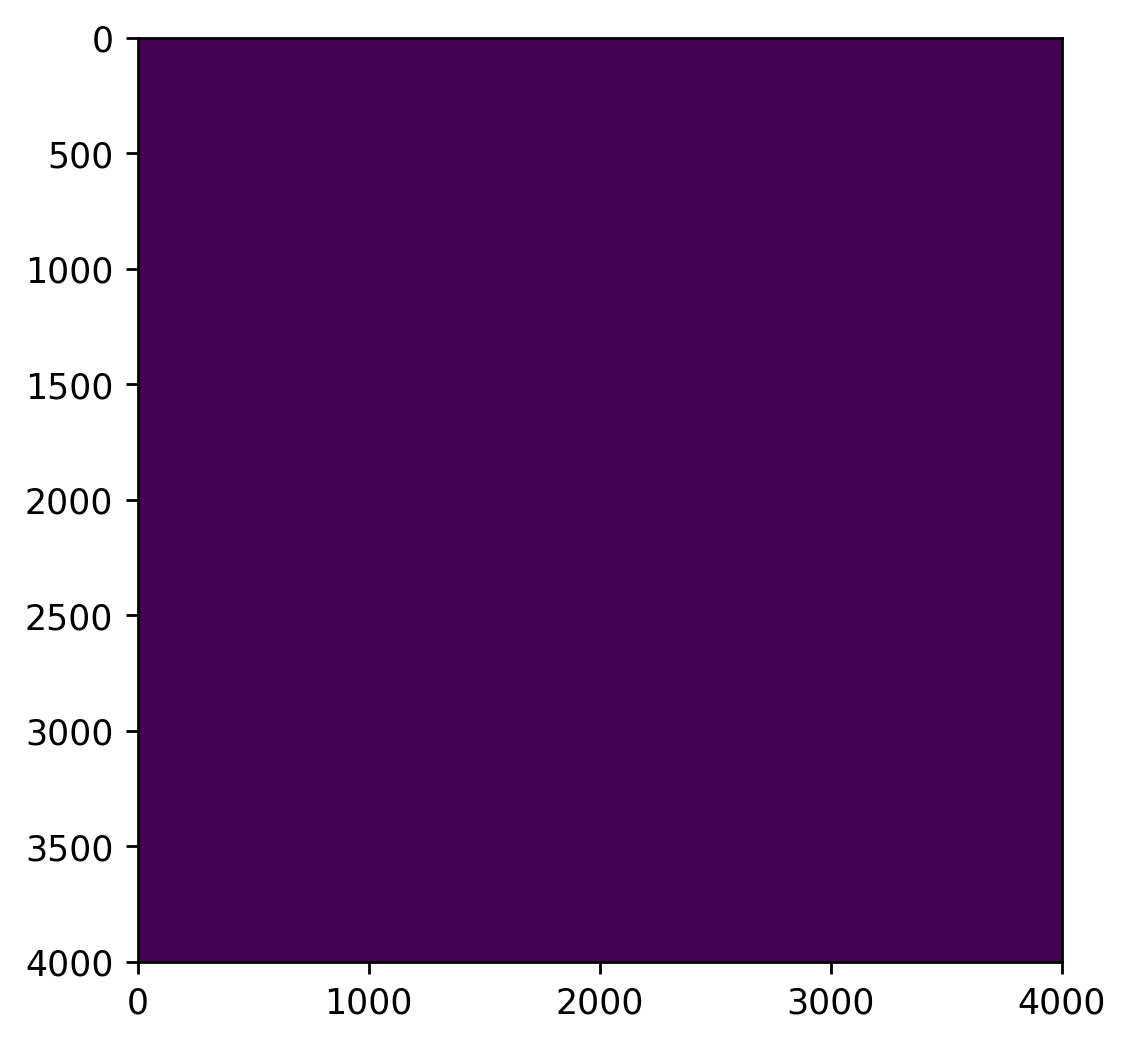

In [9]:
plt.figure(dpi=250)
plt.imshow(np.abs(E)**2)


(1800.0, 2200.0)

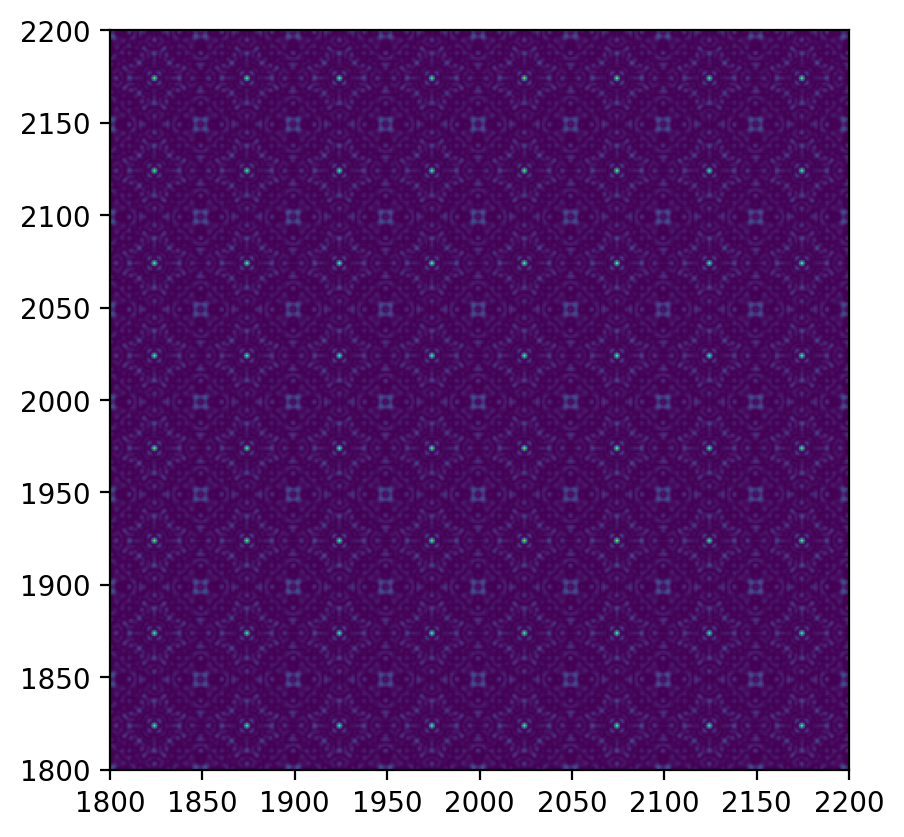

In [5]:
lamda = 800e-9
k = 2*np.pi/lamda

period = 10e-6
z = talbot_length(lamda, period)

dx = .2e-6
dy = .2e-6
eps = 1e-16

# plane of origin
x0 = np.arange(-400e-6,400e-6+eps,dx)
y0 = np.arange(-400e-6,400e-6+eps,dy)
xx0,yy0 = np.meshgrid(x0,y0)#,indexing=None) # 2D array of x and y coordinates

# calculate the impulse response of the vacuum
x = 0
y = 0
xx, yy = np.meshgrid(x,y)

x_dist = np.subtract.outer(xx,xx0)
y_dist = np.subtract.outer(yy,yy0)
r = np.sqrt(x_dist**2+y_dist**2+z**2)
h = z/r**2*np.exp(1j*k*r)/(1j*lamda)
h_fft = np.fft.fft2(np.squeeze(h))

# set up intensity grid as initial field (for testing)
E = np.zeros_like(xx0,dtype=np.complex128)
# replace every tenth pixel with a 1
for i in range(0,xx0.shape[0],int(period/dx)):
    for j in range(0,xx0.shape[1],int(period/dx)):
        E[i,j] = 1

E_fft = np.fft.fft2(E)

E_z = np.fft.fftshift(np.fft.ifft2(E_fft*h_fft))

plt.figure(dpi=200)
plt.imshow(np.abs(E_z)**2)
plt.xlim(1800,2200)
plt.ylim(1800,2200)

In [4]:
import torch

lamda = 800e-9
k = 2 * torch.tensor(torch.pi / lamda)

period = 10e-6
z = talbot_length(lamda, period)

dx = .2e-6
dy = .2e-6
eps = 1e-16

# plane of origin
x0 = torch.arange(-400e-6, 400e-6 + eps, dx)
y0 = torch.arange(-400e-6, 400e-6 + eps, dy)
xx0, yy0 = torch.meshgrid(x0, y0)
r = torch.sqrt(xx0 ** 2 + yy0 ** 2 + z ** 2)

# calculate the impulse response of the vacuum
h = z / r ** 2 * torch.exp(1j * k * r) / (1j * lamda)
h_fft = torch.fft.fft2(h.squeeze())

# set up intensity grid as initial field (for testing)
E = torch.zeros_like(xx0, dtype=torch.complex128)
# replace every tenth pixel with a 1
for i in range(0, xx0.shape[0], int(period / dx)):
    for j in range(0, xx0.shape[1], int(period / dx)):
        E[i, j] = 1

E_fft = torch.fft.fft2(E)

E_z = torch.fft.fftshift(torch.fft.ifft2(E_fft * h_fft))

/home/a/A.Doepp/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lamda = 800e-9
k = 2 * torch.tensor(torch.pi / lamda, device=device)

period = 10e-6
z = talbot_length(lamda, period)

dx = .2e-6
dy = .2e-6
eps = 1e-16

# plane of origin
x0 = torch.arange(-400e-6, 400e-6 + eps, dx, device=device)
y0 = torch.arange(-400e-6, 400e-6 + eps, dy, device=device)
xx0, yy0 = torch.meshgrid(x0, y0)
r = torch.sqrt(xx0 ** 2 + yy0 ** 2 + z ** 2)

# calculate the impulse response of the vacuum
h = z / r ** 2 * torch.exp(1j * k * r) / (1j * lamda)
h_fft = torch.fft.fft2(h.squeeze())

# set up intensity grid as initial field (for testing)
E = torch.zeros_like(xx0, dtype=torch.complex128, device=device)
# replace every tenth pixel with a 1
for i in range(0, xx0.shape[0], int(period / dx)):
    for j in range(0, xx0.shape[1], int(period / dx)):
        E[i, j] = 1

E_fft = torch.fft.fft2(E)

E_z = torch.fft.fftshift(torch.fft.ifft2(E_fft * h_fft))

In [109]:
x0 = torch.arange(-400e-6, 400e-6 + eps, dx, device=device)
y0 = torch.arange(-400e-6, 400e-6 + eps, dy, device=device)
r = torch.sqrt(x0.unsqueeze(-1) ** 2 + y0 ** 2 + z ** 2)

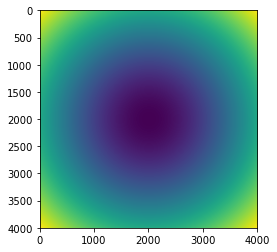

In [112]:
plt.imshow(r.cpu().numpy())

In [40]:
def propagate(E, z, x0, y0, lamda, device):
    
    dx = x0[1]-x0[0]
    dy = y0[1]-y0[0]
    k = 2 * torch.tensor(torch.pi / lamda, device=device)
    
    # calculate the impulse response of the vacuum

    r = torch.sqrt(x0.unsqueeze(-1) ** 2 + y0 ** 2 + z ** 2)
    h = (z / r ** 2) * torch.exp(1j * k * r) / (1j * lamda)

    # move to Fourier space
    h_fft = torch.fft.fft2(h)
    E_fft = torch.fft.fft2(E)

    E_z = torch.fft.fftshift(torch.fft.ifft2(E_fft * h_fft))*dx*dy

    return E_z

x_min = -400e-6
x_max = 400e-6
dx = .2e-6
x0 = torch.arange(x_min, x_max + eps, dx, device=device)

y_min = -400e-6
y_max = 400e-6
dy = .2e-6
y0 = torch.arange(y_min, y_max + eps, dy, device=device)

lamda = 800e-9

period = 10e-6
z = talbot_length(lamda, period)
E0 = torch.zeros((x0.shape[0],y0.shape[0]), dtype=torch.complex128, device=device)
E0[::10,::10] = 1


E1 = propagate(E0, z, x0, y0, lamda, device)

In [46]:
z/(x_min-x_max)

-0.3119991974297153

(1900.0, 2100.0)

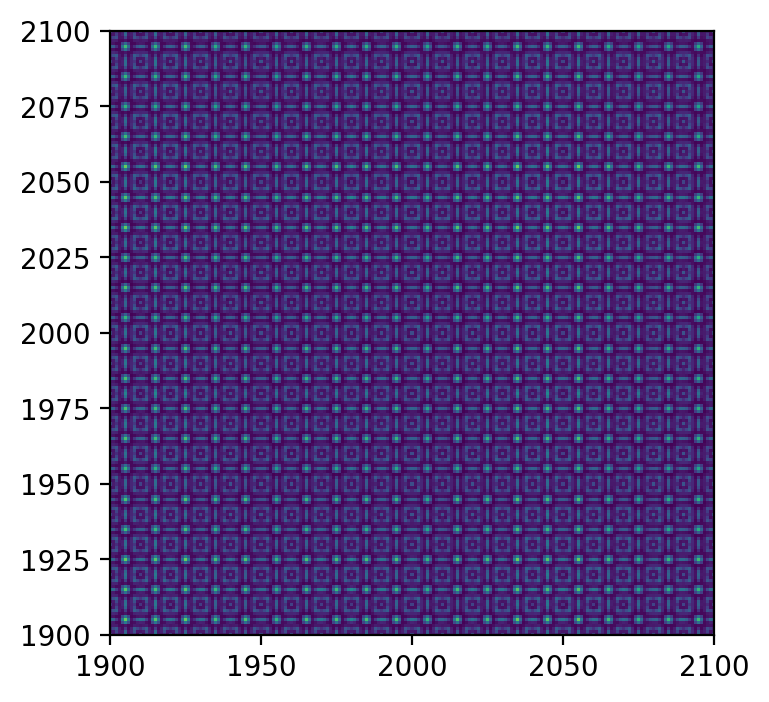

In [60]:
E0 = torch.zeros((x0.shape[0],y0.shape[0]), dtype=torch.complex128, device=device)
E0[::10,::10] = 1

E1 = torch.clone(E0)
for i in range(0,10):
    E1 = propagate(E1, 50e-6, x0, y0, lamda, device)
    E1 = propagate(E1, -50e-6, x0, y0, lamda, device)

plt.figure(dpi=200)
plt.imshow(np.abs(E1.cpu().numpy())**2)
plt.xlim(1900,2100)
plt.ylim(1900,2100)

In [71]:
talbot_length(lamda, 10*dx)/dx

249.59935794377228

In [53]:
x0.shape

(801,)

In [57]:


h.shape

(1, 1, 801, 801)

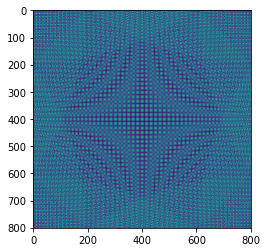

In [49]:
plt.imshow((np.squeeze(np.abs(h_fft))))

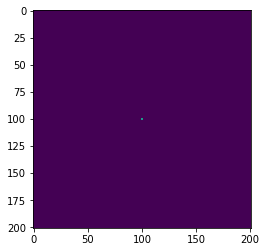

In [33]:
import pandas as pd
A = pd.read_pickle('20230510_imgs_processed.pkl')


In [40]:
# get the data with name "imgs_processed" from pickle file A
imgs_processed = A['plane1']['imgs_processed']

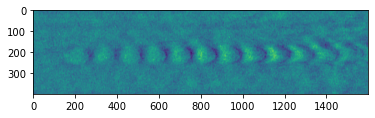

In [43]:
plt.imshow(imgs_processed)

In [47]:
imgs_processed.shape[1]*0.345/2

276.0

In [50]:
(50**2)/(50**2+150**2)

0.1

In [52]:
def diffraction_angle(wavelength, period):
    return np.arcsin(wavelength/period)

diffraction_angle(600e-9, 30e-6)*50e-6

1.0000666786695245e-06

In [29]:
import torch

x = torch.randn(200, 200, 200, 100)  # create a tensor

num_elements = torch.numel(x)
element_size = x.element_size()

memory_size = num_elements * element_size
print(f"Memory size of x: {memory_size/1e6} MB")


Memory size of x: 3200.0 MB


In [ ]:

    # Distances between initial positions and x,y coordinates
    #jitter = 2e-7
    x_dist = np.subtract.outer(xx,x0)
    #x_dist += np.random.rand(*x_dist.shape)*jitter*10 # Add random noise

    y_dist = np.subtract.outer(yy,y0)
    #y_dist += np.random.rand(*y_dist.shape)*jitter # Add random noise
    dist = np.sqrt(x_dist**2+y_dist**2)

    # Phase
    phi = np.mod(dist, wavelength)*2*np.pi/wavelength - phi0
